# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

Import necessary modules.

In [2]:
# Image features loading & display
import sys
import pickle
import pandas as pd
from IPython.display import display

# Image preprocessing and plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Deep learning
import tensorflow as tf
from tensorflow.contrib.layers import flatten

---

## Step 0: Load the Data

Load features sets from pickled files; the files provided use pickle protocol 4, while Python 2.7's pickle library doesn't support it. Each of the files has been loaded in Python 3.7, and then dumped back to a separate pickle file whose name ends with `"_2.p"`. Those pickle version 2 based files are used when Python version earlier than 3.4 is used.

In [3]:
# Load pickled data
if sys.version >= '3.4':
    training_file = './data/train.p'
    validation_file= './data/valid.p'
    testing_file = './data/test.p'
else:
    training_file = './data/train_2.p'
    validation_file= './data/valid_2.p'
    testing_file = './data/test_2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

data = {
    'Feature Set': ['Training Set', 'Validation Set', 'Test Set'],
    'Number of Samples': [n_train, n_validation, n_test]
}
df = pd.DataFrame(data)
df.style.hide_index()
display(df)
print('')
print('Image shape: {}'.format(image_shape))
print('Number of classes: {}'.format(n_classes))

,Feature Set,Number of Samples
0,Training Set,34799
1,Validation Set,4410
2,Test Set,12630



Image shape: (32, 32, 3)
Number of classes: 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

First construct a dictionary called `sign`, which maps a traffic sign id to the corresponding description and a sample image found from the validation set. This dictionary will later be used again when we plot the prediction results for new images.

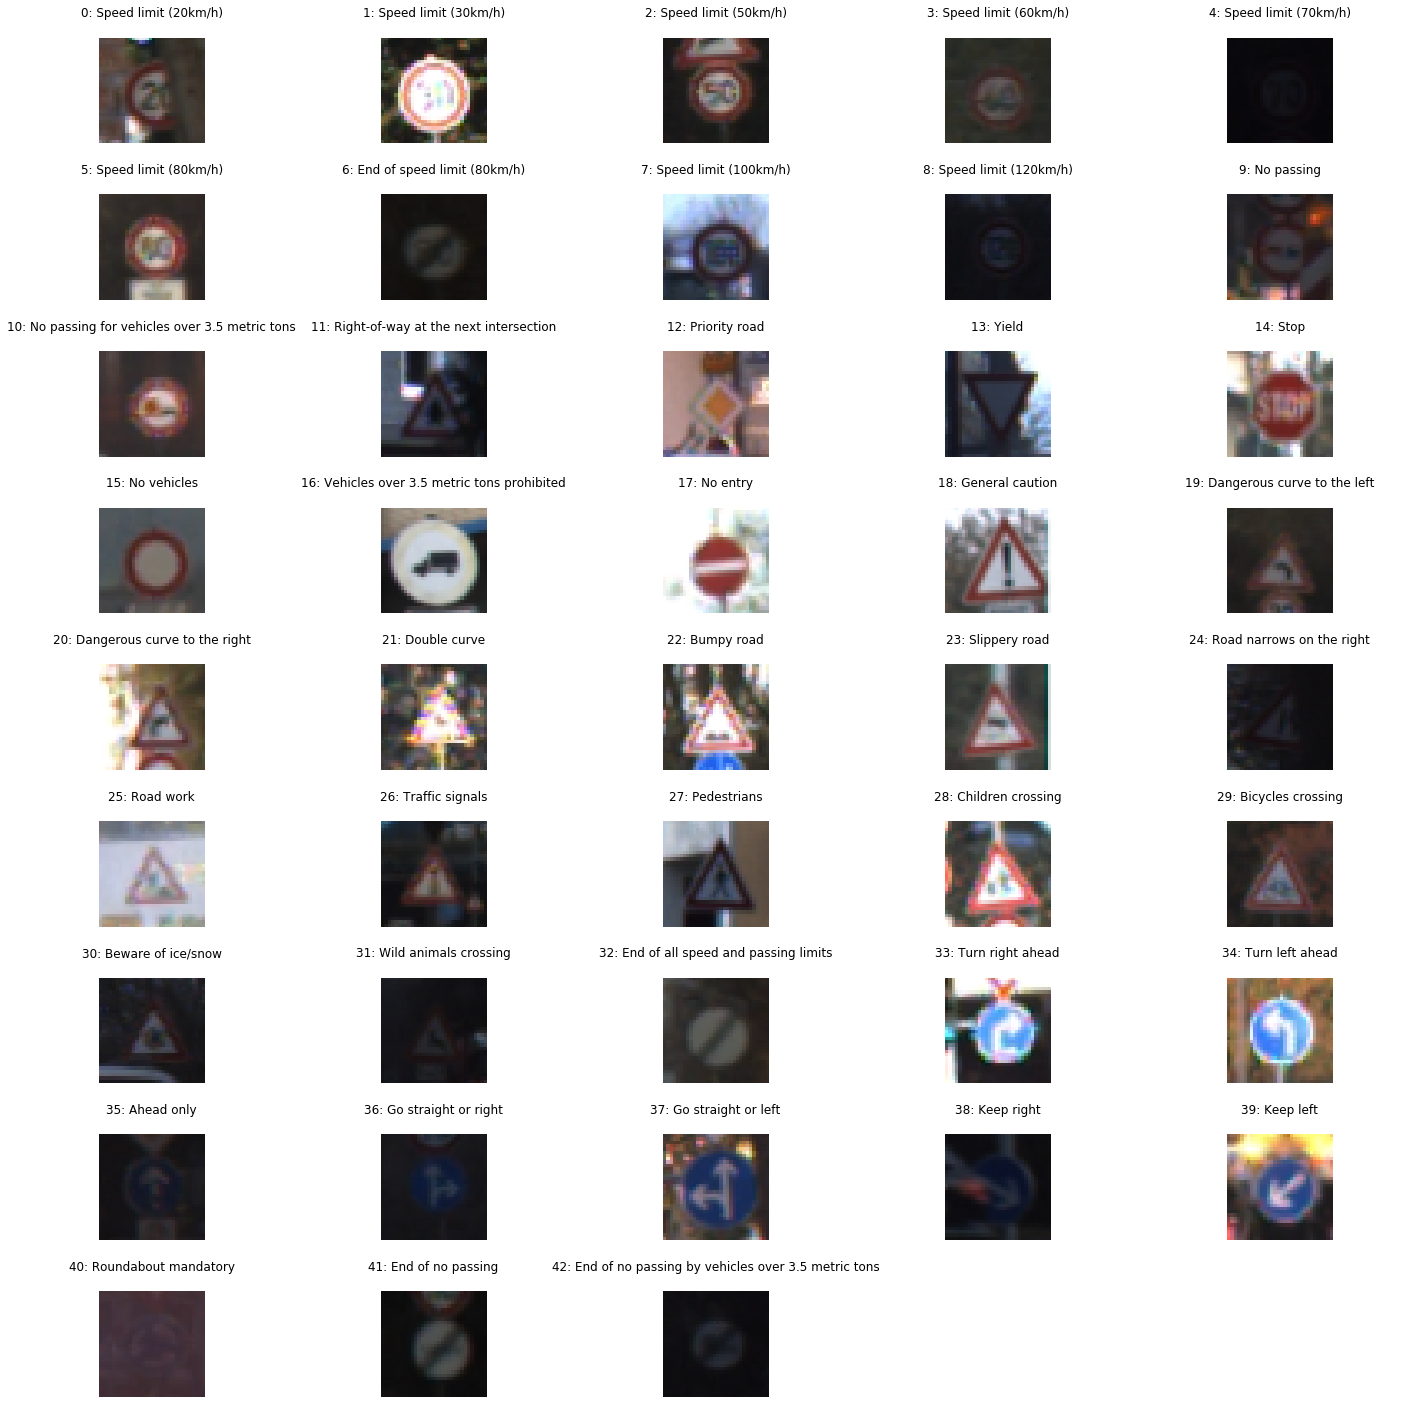

In [5]:
# Mapping from numerical id to textual info.
sign = dict()
with open('signnames.csv', 'r') as f:
    for line in f.readlines()[1:]:
        k, v = line.split(',')
        k = int(k)
        img = X_valid[np.argwhere(y_valid == k)[0][0]]
        sign[k] = {'description': v, 'sample': img}

# Display one sample image for each class of traffic sign, in a tabular format.
n_cols = 5
n_rows = n_classes // n_cols + (1 if n_classes % 5 else 0)
fig, axs = plt.subplots(ncols=5, nrows=n_rows, figsize=(20, 20))
fig.tight_layout(pad=3.0)
axs = axs.ravel()
for i in range(n_cols * n_rows):
    if i < n_classes:
        axs[i].imshow(sign[i]['sample'])
        axs[i].set_title(str(i) + ': ' + sign[i]['description'])
    axs[i].set_axis_off()

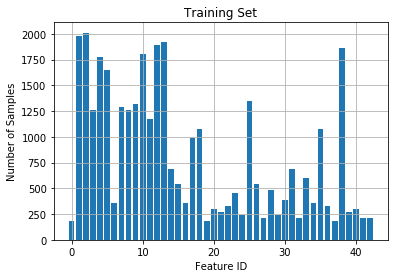

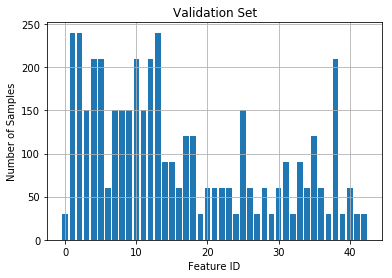

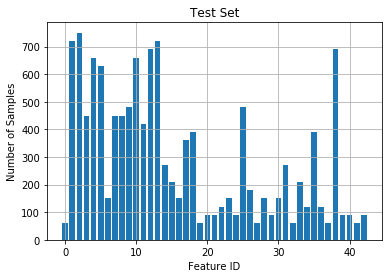

In [10]:
u, c = np.unique(y_train, return_counts=True)
plt.bar(u, c)
plt.grid()
plt.title('Training Set')
plt.xlabel('Feature ID')
plt.ylabel('Number of Samples')
plt.show()

u, c = np.unique(y_valid, return_counts=True)
plt.bar(u, c)
plt.grid()
plt.title('Validation Set')
plt.xlabel('Feature ID')
plt.ylabel('Number of Samples')
plt.show()

u, c = np.unique(y_test, return_counts=True)
plt.bar(u, c)
plt.grid()
plt.title('Test Set')
plt.xlabel('Feature ID')
plt.ylabel('Number of Samples')
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Apply simple grayscaling and normalization in the preprocessing step.

In [5]:
# 1. Obtain grayscale images.
# 2. Normalize for zero mean and equal variance.
X_train = (np.mean(X_train, axis=3, keepdims=True) - 128) / 128
X_valid = (np.mean(X_valid, axis=3, keepdims=True) - 128) / 128
X_test = (np.mean(X_test, axis=3, keepdims=True) - 128) / 128

In [6]:
### Shuffle input data

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

The LeNet architecture is used as it is, aside from two minor modificaitons:
1. The output 43 components which is the number of classes for this classifier, and
2. Dropout is applied in later stages of the pipeline.

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Keep probability for dropout
keep_prob = tf.placeholder(tf.float32)

def Classifier(x):
    # Arguments used for tf.truncated_normal
    mu = 0
    sigma = 0.1

    # Layer 1 - Convolutional (32 x 32 x 1 --> 6 @ 28 x 28)
    C1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    C1_b = tf.Variable(tf.zeros(6))
    C1 = tf.nn.conv2d(x, C1_W, strides=(1, 1, 1, 1), padding='VALID') + C1_b
    # Activation
    C1 = tf.nn.relu(C1)
    # Pooling (6 @ 28 x 28 --> 6 @ 14 x 14)
    S2 = tf.nn.max_pool(C1, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID')

    # Layer 2 - Convolutional (6 @ 14 x 14 --> 16 @ 10 x 10)
    C3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    C3_b = tf.Variable(tf.zeros(16))
    C3 = tf.nn.conv2d(S2, C3_W, strides=(1, 1, 1, 1), padding='VALID') + C3_b
    # Activation
    C3 = tf.nn.relu(C3)
    # Pooling (16 @ 10 x 10 --> 16 @ 5 x 5)
    S4 = tf.nn.max_pool(C3, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID')
    # Flatten (16 @ 5 x 5 --> 400)
    S4_f = flatten(S4)
    # Dropout for regularization
    S4_f = tf.nn.dropout(S4_f, keep_prob)

    # Layer 3 - Fully Connected (400 --> 120)
    C5_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    C5_b = tf.Variable(tf.zeros(120))
    C5 = tf.matmul(S4_f, C5_W) + C5_b
    # Activation
    C5 = tf.nn.relu(C5)
    # Dropout for regularization
    C5 = tf.nn.dropout(C5, keep_prob)

    # Layer 4 - Fully Connected (120 --> 84)
    F6_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    F6_b = tf.Variable(tf.zeros(84))
    F6 = tf.matmul(C5, F6_W) + F6_b
    # Activation
    F6 = tf.nn.relu(F6)
    # Dropout for regularization
    F6 = tf.nn.dropout(F6, keep_prob)

    # Layer 5 - Fully Connected (84 --> 43 - where 43 is the number of classes)
    output_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    output_b = tf.Variable(tf.zeros(n_classes))
    output = tf.matmul(F6, output_W) + output_b

    # return logits computed above
    return output

### Train, Validate and Test the Model

In [8]:
# Learning settings and placeholders
EPOCHS = 100
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [9]:
### Training pipeline

rate = 0.0006
logits = Classifier(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
### Model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    session = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = session.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
# Train the model
# Check accuracies both for the training and the validation set to
# indicate whether the model is underfit or overfit.

saver = tf.train.Saver()

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print('Training...')
    print('')
    training_accuracy_plot, validation_accuracy_plot = [], []
    for i in range(EPOCHS):
        print('EPOCH {}...'.format(i + 1))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        training_accuracy = evaluate(X_train, y_train)
        training_accuracy_plot.append(training_accuracy)
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_plot.append(validation_accuracy)
        print('Training Set Accuracy = {:.3f}'.format(training_accuracy))
        print('Validation Accuracy = {:.3f}'.format(validation_accuracy))
        print('')
    
    saver.save(session, './model')
    print('Model saved.')

Training...

EPOCH 1...
Training Set Accuracy = 0.290
Validation Accuracy = 0.244

EPOCH 2...
Training Set Accuracy = 0.525
Validation Accuracy = 0.480

EPOCH 3...
Training Set Accuracy = 0.646
Validation Accuracy = 0.592

EPOCH 4...
Training Set Accuracy = 0.750
Validation Accuracy = 0.715

EPOCH 5...
Training Set Accuracy = 0.819
Validation Accuracy = 0.786

EPOCH 6...
Training Set Accuracy = 0.855
Validation Accuracy = 0.811

EPOCH 7...
Training Set Accuracy = 0.870
Validation Accuracy = 0.822

EPOCH 8...
Training Set Accuracy = 0.889
Validation Accuracy = 0.842

EPOCH 9...
Training Set Accuracy = 0.901
Validation Accuracy = 0.848

EPOCH 10...
Training Set Accuracy = 0.900
Validation Accuracy = 0.845

EPOCH 11...
Training Set Accuracy = 0.916
Validation Accuracy = 0.860

EPOCH 12...
Training Set Accuracy = 0.920
Validation Accuracy = 0.865

EPOCH 13...
Training Set Accuracy = 0.927
Validation Accuracy = 0.871

EPOCH 14...
Training Set Accuracy = 0.930
Validation Accuracy = 0.870

EP

Text(0.5,1,'Validation Accuracy')

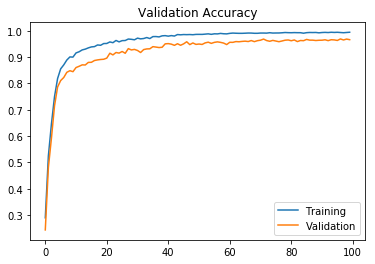

In [12]:
# Plot validation accuracy according to epoch.
plt.plot(training_accuracy_plot)
plt.plot(validation_accuracy_plot)
plt.legend(['Training', 'Validation'])
plt.title('Validation Accuracy')

In [13]:
# Run test, report its result.
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print('Test Accuracy = {:.1f}%'.format(100 * test_accuracy))

INFO:tensorflow:Restoring parameters from ./model
Test Accuracy = 94.6%


---

## Step 3: Test a Model on New Images

### Load and Output the Images

Five sample images are given by separate files in the `data` directory.

- `1.png`: (1) Speed limit (30km/h)
- `2.png`: (22) Bumpy road
- `3.png`: (35) Ahead only
- `4.png`: (15) No vehicles
- `5.png`: (37) Go straight or left

The images are loaded using `cv2`, color-converted, and then collected in a Python list. The images in the list will later be normalized with the same method used in normalizing the feature sets.

To visually verify the sample images, display them using `pyplot`.


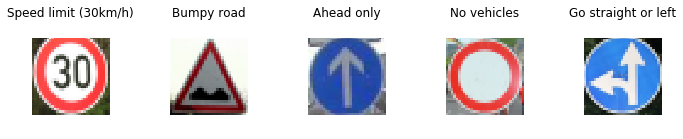

In [12]:
# Load the images and plot them.

sample_files = ['1.png', '2.png', '3.png', '4.png', '5.png']
sample_labels = [1, 22, 35, 15, 37]
images = []
for file in sample_files:
    img = cv2.cvtColor(cv2.imread('./data/' + file), cv2.COLOR_BGR2RGB)
    images.append(img)

fig, axs = plt.subplots(1, len(images), figsize=(10, 10))
fig.tight_layout(pad=3.0)
for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].set_title(sign[sample_labels[i]]['description'])
    axs[i].set_axis_off()

In [27]:
# Get summary of sample images.
shapes = [img.shape for img in images]
brightness = []
contrast = []
for img in images:
    hsv = img.copy()
    b = np.mean(hsv[:,:,2])
    brightness.append('{:.1f}%'.format(b * 100 / 255))
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    kernel = np.ones((5, 5), np.uint8)
    minv = (cv2.erode(L, kernel, iterations=1)).astype(np.float32)
    maxv = (cv2.dilate(L, kernel, iterations=1)).astype(np.float32)
    c = np.mean((maxv - minv) / (maxv + minv))
    contrast.append('{:.1f}%'.format(c * 100))

data = {
    'Image File': sample_files,
    'Shape': shapes,
    'Brightness': brightness,
    'Contrast': contrast,
}
df = pd.DataFrame(data)
df.style.hide_index()
display(df)

,Image File,Shape,Brightness,Contrast
0,1.png,"(32, 32, 3)",50.9%,48.0%
1,2.png,"(32, 32, 3)",58.6%,45.4%
2,3.png,"(32, 32, 3)",64.4%,28.7%
3,4.png,"(32, 32, 3)",60.3%,22.4%
4,5.png,"(32, 32, 3)",73.3%,42.5%


### Predict the Sign Type for Each Image

Since prediction takes the class with the highest probability defined by softmax, we calculate the `top_k` using the model trained above. The reason we take the `top_k` is that we want to display those images for analysis purposes.

In [15]:
# Run prediction by top_k operation.
saver = tf.train.Saver()

k = 5
n = len(images)

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k)

# Preprocess the images.
X_prediction = (np.mean(images, axis=3, keepdims=True) - 128) / 128
y_prediction = np.array(sample_labels)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver.restore(session, './model')
    prediction = session.run(top_k, feed_dict={x: X_prediction, y: y_prediction, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./model


### Analyze Performance

Calculate the accuracy for the five images shwon above.

In [16]:
# Calculate the accuracy for these 5 new images. 

correct = 0
for i in range(n):
    if prediction[1][i][0] == y_prediction[i]:
        s = 'correct'
        correct += 1
    else:
        s = 'incorrect'
    print(
        'Sample #{} - ({}) label: {}, prediction: {}'.format(
            i + 1, s, y_prediction[i], prediction[1][i][0]
        )
    )
print('')
print('Accuracy = {:.1f}%'.format(correct * 100 / n))

Sample #1 - (correct) label: 1, prediction: 1
Sample #2 - (correct) label: 22, prediction: 22
Sample #3 - (correct) label: 35, prediction: 35
Sample #4 - (correct) label: 15, prediction: 15
Sample #5 - (correct) label: 37, prediction: 37

Accuracy = 100.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

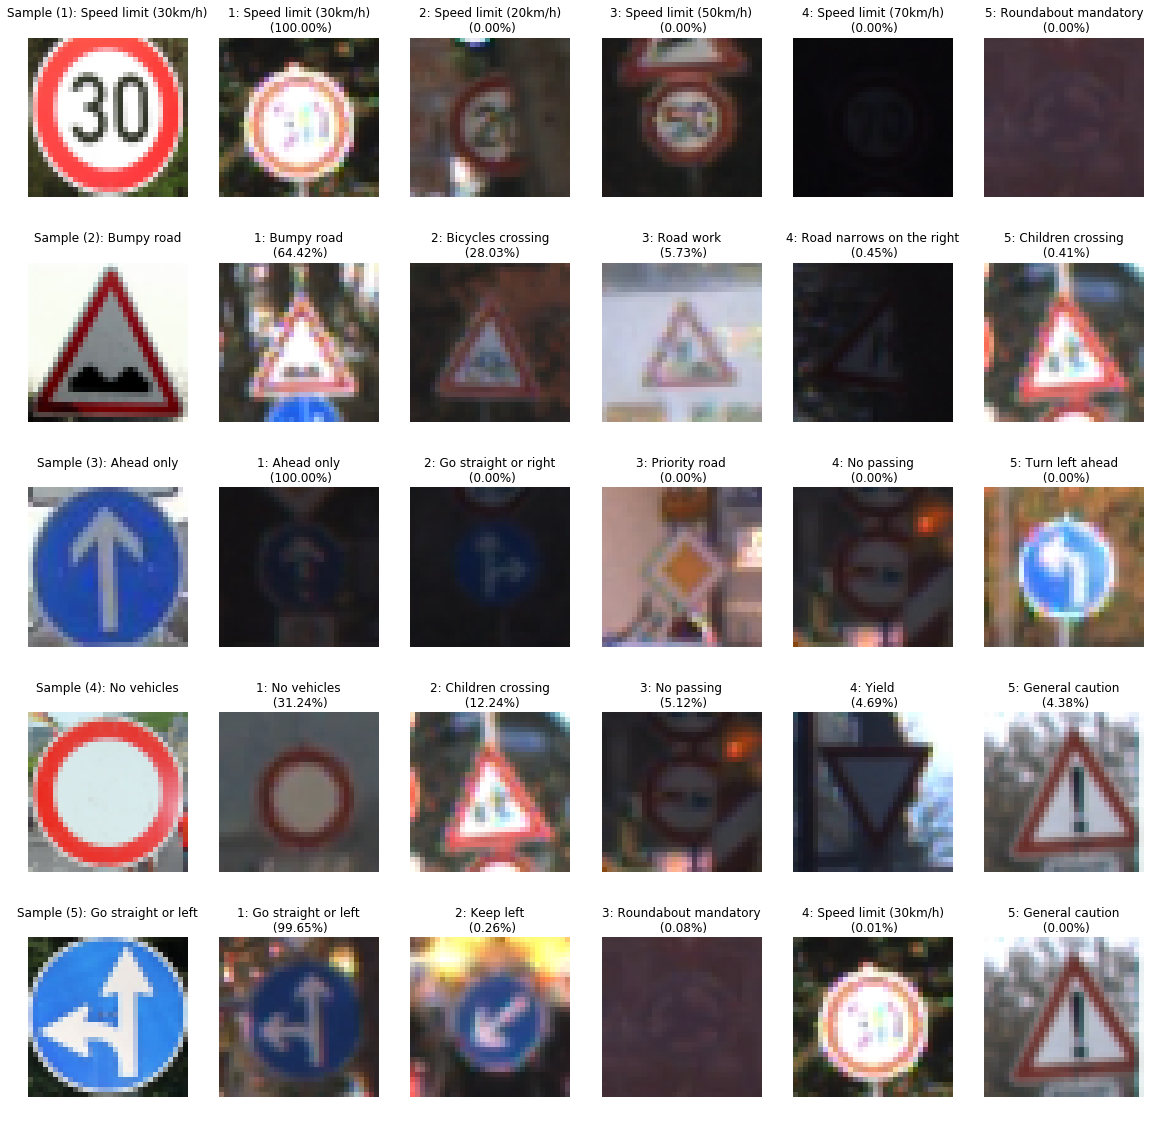

In [17]:
# For each image being predicted, show top five matched images that are
# selected among the validation set.
fig, axs = plt.subplots(ncols=k + 1, nrows=n, figsize=(20, 20))
for i in range(n):
    axs[i][0].imshow(images[i])
    title = 'Sample ({}): {}'.format(
        i + 1,
        sign[y_prediction[i]]['description']
    )
    axs[i][0].set_title(title)
    axs[i][0].set_axis_off()
    for j in range(k):
        axs[i][j + 1].imshow(sign[prediction[1][i][j]]['sample'])
        title = '{}: {} ({:.2f}%)'.format(
            j + 1,
            sign[prediction[1][i][j]]['description'],
            100 * prediction[0][i][j]
        )
        axs[i][j + 1].set_title(title)
        axs[i][j + 1].set_axis_off()